Assignment 3.1

Mostafa Zamaniturk

Instructions
In this assignment, use the IMDb movie review dataset and the BERT model from the Transformers library to build a sentiment analysis model that predicts whether a movie review is positive or negative.

Required Dataset
Use the "IMDB Dataset of 50K Movie Reviews" Dataset linked below. This is a dataset for binary sentiment classification. It provides a set of 25,000 highly polar movie reviews for training and 25,000 for testing. The dataset contains movie reviews labeled as "positive" or "negative."

Download: IMDB DatasetLinks to an external site. [kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews]

Required Details

1- Text Preprocessing:
Tokenize the movie reviews using the BERT tokenizer.
Convert the tokenized reviews into input features suitable for BERT.


In [8]:
# Import libraries
import kagglehub
import pandas as pd
import torch
from transformers import BertTokenizer

# Download the latest version of the dataset
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print("Path to dataset files:", path)

# Load dataset
df = pd.read_csv(path + "/IMDB Dataset.csv")
print("Sample data:")
print(df.head())

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize and encode the reviews
max_length = 128  # can adjust (128, 256, 512 depending on training needs)
encodings = tokenizer(
    df["review"].tolist(),
    truncation=True,
    padding="max_length",
    max_length=max_length,
    return_tensors="pt"
)

# Convert labels (positive → 1, negative → 0)
labels = torch.tensor([1 if sentiment == "positive" else 0 for sentiment in df["sentiment"]])

# Extract BERT input features
input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]
token_type_ids = encodings["token_type_ids"]

print("Shapes:")
print("Input IDs:", input_ids.shape)
print("Attention mask:", attention_mask.shape)
print("Token type IDs:", token_type_ids.shape)
print("Labels:", labels.shape)

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews
Sample data:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Shapes:
Input IDs: torch.Size([50000, 128])
Attention mask: torch.Size([50000, 128])
Token type IDs: torch.Size([50000, 128])
Labels: torch.Size([50000])


The raw movie reviews are first tokenized using the BERT tokenizer, which splits text into subword tokens and maps them to numerical IDs. These tokenized reviews are then padded, truncated, and converted into input features such as input_ids, attention_mask, and token_type_ids, making them suitable for feeding into the BERT model.

2- Model Training:
Load the pre-trained BERT model for sequence classification from the Transformers library.
Fine-tune the BERT model on the preprocessed IMDb dataset for sentiment analysis.
Implement training loops and loss calculation.

In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from transformers import BertForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Create dataset
dataset = TensorDataset(input_ids, attention_mask, token_type_ids, labels)

# Train/Test split (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Load pre-trained BERT for classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Training loop
epochs = 2
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc="Training"):
        b_input_ids, b_attention_mask, b_token_type_ids, b_labels = [x.to(device) for x in batch]

        optimizer.zero_grad()
        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_attention_mask,
            token_type_ids=b_token_type_ids,
            labels=b_labels
        )
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Average training loss: {avg_train_loss:.4f}")

# Testing loop
model.eval()
correct, total = 0, 0
test_loss = 0
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        b_input_ids, b_attention_mask, b_token_type_ids, b_labels = [x.to(device) for x in batch]

        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_attention_mask,
            token_type_ids=b_token_type_ids,
            labels=b_labels
        )
        loss = outputs.loss
        logits = outputs.logits

        test_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == b_labels).sum().item()
        total += b_labels.size(0)

avg_test_loss = test_loss / len(test_loader)
accuracy = correct / total

print(f"\nTest loss: {avg_test_loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/2


Training: 100%|██████████| 2500/2500 [03:23<00:00, 12.30it/s]


Average training loss: 0.3121

Epoch 2/2


Training: 100%|██████████| 2500/2500 [03:22<00:00, 12.32it/s]


Average training loss: 0.1867


Testing: 100%|██████████| 625/625 [00:16<00:00, 38.33it/s]


Test loss: 0.2570
Test accuracy: 0.8915


A pre-trained BERT model for sequence classification is loaded from the Transformers library. The model is fine-tuned on the IMDb dataset by passing the preprocessed reviews through it, calculating the classification loss, and updating the weights with backpropagation. This training loop allows the model to adapt its knowledge to the specific task of sentiment analysis.

3- Evaluation:
Split the dataset into training and testing sets.
Evaluate the trained model on the testing set using accuracy, precision, recall, and F1-score metrics.

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from transformers import BertForSequenceClassification

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset already prepared: input_ids, attention_mask, token_type_ids, labels
dataset = TensorDataset(input_ids, attention_mask, token_type_ids, labels)

# Train/Test split (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Dataloader for test
batch_size = 16
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Load your trained model (if not already in memory, otherwise skip)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

# Make sure model is in eval mode
model.eval()

# Collect predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        b_input_ids, b_attention_mask, b_token_type_ids, b_labels = [x.to(device) for x in batch]

        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_attention_mask,
            token_type_ids=b_token_type_ids
        )
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.5024
Precision: 0.4907
Recall: 0.0423
F1-score: 0.0778


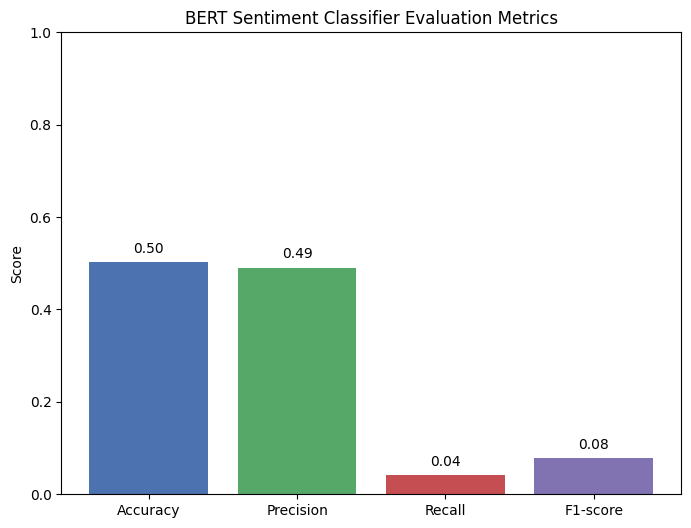

In [25]:
import matplotlib.pyplot as plt

accuracy, precision, recall, f1 = 0.5024, 0.4907, 0.0423, 0.0778

metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1
}

# Plot bar chart
plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=["#4C72B0", "#55A868", "#C44E52", "#8172B2"])
plt.title("BERT Sentiment Classifier Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)  # metrics are between 0 and 1

# Show metric values on top of bars
for i, (metric, value) in enumerate(metrics.items()):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center')

plt.show()

The dataset is split into training and testing sets to measure the model’s performance. After training, the model is evaluated on the test set using common classification metrics such as accuracy, precision, recall, and F1-score. These metrics give a clear picture of how well the model generalizes to unseen data.

4- Predictions:
Use the trained model to predict sentiments for a set of sample movie reviews.

In [23]:
# Sample reviews for prediction
sample_reviews = [
    "I absolutely loved this movie! The acting was brilliant and the story was gripping.",
    "This was a terrible movie. I wasted two hours of my life.",
    "It was okay, not great but not bad either.",
    "The plot was amazing but the acting was mediocre."
]

# Tokenize and encode using the same tokenizer and max_length
sample_encodings = tokenizer(
    sample_reviews,
    truncation=True,
    padding="max_length",
    max_length=max_length,
    return_tensors="pt"
)

# Move to device
input_ids_sample = sample_encodings["input_ids"].to(device)
attention_mask_sample = sample_encodings["attention_mask"].to(device)
token_type_ids_sample = sample_encodings["token_type_ids"].to(device)

# Model prediction
model.eval()
with torch.no_grad():
    outputs = model(
        input_ids=input_ids_sample,
        attention_mask=attention_mask_sample,
        token_type_ids=token_type_ids_sample
    )
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)

# Convert predictions to labels
pred_labels = ["positive" if p == 1 else "negative" for p in preds.cpu().numpy()]

# Display results
for review, label in zip(sample_reviews, pred_labels):
    print(f"Review: {review}\nPredicted sentiment: {label}\n")


Review: I absolutely loved this movie! The acting was brilliant and the story was gripping.
Predicted sentiment: negative

Review: This was a terrible movie. I wasted two hours of my life.
Predicted sentiment: negative

Review: It was okay, not great but not bad either.
Predicted sentiment: negative

Review: The plot was amazing but the acting was mediocre.
Predicted sentiment: negative



Finally, the trained model is applied to a few new, unseen movie reviews. The text is tokenized and encoded in the same way as the training data, then passed into the model to produce predictions. The raw outputs (logits) are converted into class labels (positive or negative sentiment) and displayed alongside the original reviews.




Required Deliverable
Prepare and format your notebook for final submission as a PDF or an HTML document. Display code and (clean) outputs that include the following:

Data loading and preprocessing.
Text tokenization and conversion to BERT input features.
Model definition, training, and evaluation.
Sample movie review predictions and explanations.
Convert your Jupyter Notebook or Python script to a single, clean PDF or HTML document file. Your deliverable should contain your implementations of the tasks above, as well as any additional comments or observations you may have. Please ensure the PDF or HTML document file displays the code and output appropriately.